In [1]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import bitstring
from qiskit_aer import AerSimulator

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

from qiskit.circuit.library import UnitaryGate

In [2]:
matrix_h = ([[2**(-0.5),2**(-0.5)],[2**(-0.5),-2**(-0.5)]])
h_ideal = UnitaryGate(matrix_h)

matrix_cx = ([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
cx_ideal = UnitaryGate(matrix_cx)       #Erst Target, dann Control Qubit!!

matrix_x = ([[0,1],[1,0]])
x_ideal = UnitaryGate(matrix_x)

matrix_z = ([[1,0],[0,-1]])
z_ideal = UnitaryGate(matrix_z)

In [7]:
def rot_surf_code(n: int) -> QuantumCircuit:              #1st anc = third last qubit = syndrome/parity measurement qubit, 2nd anc = sec last qubit = magic state for S Gate, 3rd anc = last qubit = magic state for T-Gate
    qr = QuantumRegister(4*n+3, "q")
    cbit = ClassicalRegister(100,"c")
    qc = QuantumCircuit(qr,cbit)
    list = []
    for i in range(0, 9*n):
        list.append("{:c}".format(i))
    list = qr
    for i in range(n):
        qc.h(list[4*i+0])
        qc.cx(list[4*i+0],list[4*i+1])
        qc.cx(list[4*i+0],list[4*i+2])
        qc.cx(list[4*i+0],list[4*i+3])
    return qc

def X_L(circuit: QuantumCircuit, had: False ,n=0):        
    qc = circuit
    if had:
        qc.x(4*n+0)
        qc.x(4*n+2)
    else:
        qc.x(4*n+0)
        qc.x(4*n+1)
    return qc

def Z_L(circuit: QuantumCircuit, had = False, n=0):            #n muss bei 0 anfangen, also z.B. man hat 3 Circuits und will Z_L auf den ersten anwenden ---> n = 0 !!!
    qc = circuit
    if had:
        qc.z(4*n+0)
        qc.z(4*n+1)
    else:
        qc.z(4*n+0)
        qc.z(4*n+2)
    return qc

def Hadamard(circuit: QuantumCircuit, pos=0):              #H-Gates auf EINEN Circuit, wieder erster Circuit --> n = 0, zweiter Circuit --> n = 1 , usw.
    for i in range(4):
        circuit.h(4*pos+i)
    return circuit

def S_L(qc: QuantumCircuit, had = False, pos=0):
    ancilla = qc.num_qubits - 3
    magic_S = ancilla + 1
    qc.reset(magic_S)
    qc.reset(ancilla)

    #qc.h(magic_S)
    qc.append(h_ideal,[magic_S])
    qc.s(magic_S)

    qc.cx(magic_S,ancilla)
    qc = Z_parity(qc, hadamard=had, pos=pos)

    qc.measure(ancilla, 0)

    if had == False:
        with qc.if_test((0,1)):
            qc.z(0+4*pos)
            qc.z(2+4*pos)
    else:
        with qc.if_test((0,1)):
            qc.z(0+4*pos)
            qc.z(1+4*pos)
    
    #qc.h(magic_S)
    qc.append(h_ideal,[magic_S])
    qc.measure(magic_S,0)
    
    if had == False:
        with qc.if_test((0,1)):
            qc.z(0+4*pos)
            qc.z(2+4*pos)
    else:
        with qc.if_test((0,1)):
            qc.z(0+4*pos)
            qc.z(1+4*pos)  
    return qc

def adjoint_S_L(qc: QuantumCircuit, had = False, pos=0):
    ancilla = qc.num_qubits - 3
    magic_S = ancilla + 1
    qc.reset(magic_S)
    qc.reset(ancilla)

    #qc.h(magic_S)
    qc.append(h_ideal,[magic_S])
    qc.sdg(magic_S)

    qc.cx(magic_S,ancilla)
    qc = Z_parity(qc, hadamard=had, pos= pos)

    qc.measure(ancilla, 0)

    if had == False:
        with qc.if_test((0,1)):
            qc.z(0+4*pos)
            qc.z(2+4*pos)
    else:
        with qc.if_test((0,1)):
            qc.z(0+4*pos)
            qc.z(1+4*pos)
    
    #qc.h(magic_S)
    qc.append(h_ideal,[magic_S])
    qc.measure(magic_S,0)
    
    if had == False:
        with qc.if_test((0,1)):
            qc.z(0+4*pos)
            qc.z(2+4*pos)
    else:
        with qc.if_test((0,1)):
            qc.z(0+4*pos)
            qc.z(2+4*pos)  
    return qc

def Z_parity(circuit: QuantumCircuit, hadamard = False, pos = 0):
    qc = circuit
    ancilla = qc.num_qubits - 3
    if hadamard:
        qc.cx(0+4*pos,ancilla)
        qc.cx(1+4*pos,ancilla)
    else:
        qc.cx(0+4*pos,ancilla)
        qc.cx(2+4*pos,ancilla)
    return qc

def X_parity(circuit: QuantumCircuit, hadamard = False, pos = 0):
    qc = circuit
    ancilla = qc.num_qubits - 3
    #qc.h(ancilla)
    if hadamard:
        qc.cx(ancilla,0+4*pos)
        qc.cx(ancilla,2+4*pos)
    else:
        qc.cx(ancilla,0+4*pos)
        qc.cx(ancilla,1+4*pos)
    #qc.h(ancilla)
    return qc
    
def T_L(circuit: QuantumCircuit, had = False, pos = 0):
    qc = circuit
    ancilla = qc.num_qubits - 3
    magic_S = ancilla + 1
    magic_T = ancilla + 2
    qc.reset(magic_T)
    qc.reset(ancilla)
    
    #qc.h(magic_T)
    qc.append(h_ideal,[magic_T])
    qc.t(magic_T)                 #Initliaisierung vom Magic State

    qc = Z_parity(qc, hadamard=had, pos = pos)

    qc.cx(magic_T, ancilla)

    qc.measure(ancilla,0)
    
    if had == False:
        with qc.if_test((0,1)):         #S_L von Dustin
            qc.reset(magic_S)
            qc.reset(ancilla)
            #qc.h(magic_S)
            qc.append(h_ideal,[magic_S])
            qc.s(magic_S)

            qc.cx(magic_S,ancilla)
            qc.cx(0+4*pos,ancilla)
            qc.cx(2+4*pos,ancilla)

            qc.measure(ancilla,0)
            with qc.if_test((0,1)):
                qc.z(0+4*pos)
                qc.z(2+4*pos)
            #qc.h(magic_S)
            qc.append(h_ideal,[magic_S])
            qc.measure(magic_S,0)
            with qc.if_test((0,1)):
                qc.z(0+4*pos)
                qc.z(2+4*pos)

    else:                               
        with qc.if_test((0,1)):
            qc.reset(magic_S)
            qc.reset(ancilla)
            #qc.h(magic_S)
            qc.append(h_ideal,[magic_S])
            qc.s(magic_S)

            qc.cx(magic_S,ancilla)
            qc.cx(0+4*pos,ancilla)
            qc.cx(1+4*pos,ancilla)
            
            qc.measure(ancilla,0)
            with qc.if_test((0,1)):
                qc.z(0+4*pos)
                qc.z(1+4*pos)
            #qc.h(magic_S)
            qc.append(h_ideal,[magic_S])
            qc.measure(magic_S,0)
            with qc.if_test((0,1)):
                qc.z(0+4*pos)
                qc.z(1+4*pos)
    
    #qc.h(magic_T)
    qc.append(h_ideal,[magic_T])
    qc.measure(magic_T,0)
    
    if had == False:
        with qc.if_test((0,1)):
            qc.z(0+4*pos)
            qc.z(2+4*pos)
    else:
        with qc.if_test((0,1)):
            qc.z(0+4*pos)
            qc.z(1+4*pos)
    return qc

def adjoint_T_L(circuit: QuantumCircuit, had = False, pos = 0):
    qc = circuit
    ancilla = qc.num_qubits - 3
    magic_S = ancilla + 1
    magic_T = ancilla + 2
    qc.reset(magic_T)
    qc.reset(ancilla)
    
    #qc.h(magic_T)
    qc.append(h_ideal,[magic_T])
    qc.tdg(magic_T)                 #Initliaisierung vom Magic State

    qc = Z_parity(qc, hadamard=had, pos = pos)

    qc.cx(magic_T, ancilla)

    qc.measure(ancilla,0)
    
    if had == False:
        with qc.if_test((0,1)):         #S_L von Dustin
            qc.reset(magic_S)
            qc.reset(ancilla)
            #qc.h(magic_S)
            qc.append(h_ideal,[magic_S])
            qc.sdg(magic_S)

            qc.cx(magic_S,ancilla)
            qc.cx(0+4*pos,ancilla)
            qc.cx(2+4*pos,ancilla)

            qc.measure(ancilla,0)
            with qc.if_test((0,1)):
                qc.z(0+4*pos)
                qc.z(2+4*pos)
            #qc.h(magic_S)
            qc.append(h_ideal,[magic_S])
            qc.measure(magic_S,0)
            with qc.if_test((0,1)):
                qc.z(0+4*pos)
                qc.z(2+4*pos)

    else:                               
        with qc.if_test((0,1)):
            qc.reset(magic_S)
            qc.reset(ancilla)
            #qc.h(magic_S)
            qc.append(h_ideal,[magic_S])
            qc.sdg(magic_S)

            qc.cx(magic_S,ancilla)
            qc.cx(0+4*pos,ancilla)
            qc.cx(1+4*pos,ancilla)
            
            qc.measure(ancilla,0)
            with qc.if_test((0,1)):
                qc.z(0+4*pos)
                qc.z(1+4*pos)
            #qc.h(magic_S)
            qc.append(h_ideal,[magic_S])
            qc.measure(magic_S,0)
            with qc.if_test((0,1)):
                qc.z(0+4*pos)
                qc.z(1+4*pos)
    
    #qc.h(magic_T)
    qc.append(h_ideal,[magic_T])
    qc.measure(magic_T,0)
    
    if had == False:
        with qc.if_test((0,1)):
            qc.z(0+4*pos)
            qc.z(2+4*pos)
    else:
        with qc.if_test((0,1)):
            qc.z(0+4*pos)
            qc.z(1+4*pos)
    return qc

def CNOT(circuit:QuantumCircuit, control = 0):               #CNOT mit berücksichtigung der Rotation durch H-Gate
    if control == 0:
        for i in range(4):
            circuit.cx(i,4+i)
    else:
        for i in range(4):
            circuit.cx(4+i,i) 
    return circuit

def control_S_L(circuit: QuantumCircuit, hadamard = "00", control = 0, target = 1):
    qc = circuit

    if control == 0:

        if hadamard == "01":
            qc = T_L(qc, had=False, pos=control)
            qc = T_L(qc, had=True, pos=target)
            qc = CNOT(qc,control=control)
            qc = adjoint_T_L(qc,had=True,pos=target)
            qc = CNOT(qc,control=control)
        elif hadamard == "10":
            qc = T_L(qc, had=True, pos=control)
            qc = T_L(qc, had=False, pos=target)
            qc = CNOT(qc,control=control)
            qc = adjoint_T_L(qc,had=False,pos=target)
            qc = CNOT(qc,control=control)
        else:   #hadamard = "00" = "11"
            qc = T_L(qc, had=False, pos=control)
            qc = T_L(qc, had=False, pos=target)
            qc = CNOT(qc,control=control)
            qc = adjoint_T_L(qc,had=False,pos=target)
            qc = CNOT(qc,control=control)

    elif control == 1:

        if hadamard == "01":
            qc = T_L(qc, had=True, pos=control)
            qc = T_L(qc, had=False, pos=target)
            qc = CNOT(qc,control=control)
            qc = adjoint_T_L(qc,had=False,pos=target)
            qc = CNOT(qc,control=control)
        elif hadamard == "10":
            qc = T_L(qc, had=False, pos=control)
            qc = T_L(qc, had=True, pos=target)
            qc = CNOT(qc, control=control)
            qc = adjoint_T_L(qc,had=True,pos=target)
            qc = CNOT(qc, control=control)
        else:   #hadamard = "00" = "11"
            qc = T_L(qc, had=False, pos=control)
            qc = T_L(qc, had=False, pos=target)
            qc = CNOT(qc, control=control)
            qc = adjoint_T_L(qc,had=False,pos=target)
            qc = CNOT(qc, control=control)

    return qc

def control_Z_L(circuit: QuantumCircuit ,control = 0, target = 1):
    qc = circuit
    qc = Hadamard(qc, pos = target)
    qc = CNOT(qc, control = control)            #aufgrund des H eine Zeile drüber, geht das normale CNOT
    qc = Hadamard(qc, pos = target)
    return qc

def control_Z_L_test(circuit: QuantumCircuit, hadamard = "00", control = 0, target = 1):
    qc = circuit
    qc = S_L(qc, hadamard=False, pos=control)
    qc = S_L(qc, hadamard=True, pos=target)
    qc = CNOT(qc, hadamard=hadamard,control=control)
    qc = adjoint_S_L(qc,hadamard=True,pos=target)
    qc = CNOT(qc, hadamard=hadamard,control=control)
    return qc

def stabilize(circuit: QuantumCircuit, hadamard = False, pos = 0, round=3):                     #misst alle stabilizer, speichert den Fehler und korrigiert dementsprechend
    qc = circuit
    ancilla = qc.num_qubits - 3
    if hadamard:
        #X0 X1 Stabilizer
        qc.reset(ancilla)
        qc.h(ancilla)
        qc.cx(ancilla, 0+4*pos)
        qc.cx(ancilla, 1+4*pos)
        qc.h(ancilla)
        qc.measure(ancilla,round)
        round += round

        #X2 X3 Stabilizer
        qc.reset(ancilla)
        qc.h(ancilla)
        qc.cx(ancilla, 2+4*pos)
        qc.cx(ancilla, 3+4*pos)
        qc.h(ancilla)
        qc.measure(ancilla,round)
        round += round

    ###########################################################################################################

        #Z0 Z1 Z2 Z3 Stabilizer:
        qc.reset(ancilla)
        qc.cx(1+4*pos,ancilla)
        qc.cx(2+4*pos,ancilla)
        qc.cx(4+4*pos,ancilla)
        qc.cx(5+4*pos,ancilla)
        qc.measure(ancilla,round)
        round += round

    else:
        #X0 X1 X2 X3 Stabilizer:
        qc.reset(ancilla)
        qc.h(ancilla)
        qc.cx(ancilla, 0+4*pos)
        qc.cx(ancilla, 1+4*pos)
        qc.cx(ancilla, 2+4*pos)
        qc.cx(ancilla, 3+4*pos)
        qc.h(ancilla)
        qc.measure(ancilla,round)
        round += round

    ###########################################################################################################

        #Z0 Z1 Stabilizer:
        qc.reset(ancilla)
        qc.cx(0+4*pos,ancilla)
        qc.cx(1+4*pos,ancilla)
        qc.measure(ancilla,round)
        round += round

        #Z2 Z3 Stabilizer:
        qc.reset(ancilla)
        qc.cx(2+4*pos,ancilla)
        qc.cx(3+4*pos,ancilla)
        qc.measure(ancilla,round)
        round += round

    return qc, round

def QEC(circuit: QuantumCircuit, hadamard = False, pos = 0, iterations = 1, round = 3):
    for i in range(iterations):
        circuit, round = stabilize(circuit=circuit, hadamard=hadamard, pos=pos, round=round)
    return  circuit, round

def gates(circuit:QuantumCircuit):
    qc = circuit
    hmm = dict(qc.count_ops())
    return print("Amount of gates in this circuit: ", sum(hmm.values()))

In [4]:
def new_T_L(circuit: QuantumCircuit, had = False, pos = 0):
    qc = circuit
    ancilla = qc.num_qubits - 3
    magic_S = ancilla + 1
    magic_T = ancilla + 2
    qc.reset(magic_T)
    qc.reset(ancilla)

    qc.append(h_ideal,[magic_T])
    qc.t(magic_T) 

    if had == False:
        qc.cx(0+4*pos, magic_T)
        qc.cx(2+4*pos, magic_T)
    else:
        qc.cx(0+4*pos, magic_T)
        qc.cx(1+4*pos, magic_T)

    qc.measure(magic_T,0)

    if had == False:
        with qc.if_test((0,1)):
            qc.reset(magic_S)
            qc.reset(ancilla)
            #qc.h(magic_S)
            qc.append(h_ideal,[magic_S])
            qc.s(magic_S)

            qc.cx(0+4*pos, magic_S)
            qc.cx(2+4*pos, magic_S)

            qc.measure(magic_S,0)

            with qc.if_test((0,1)):
                qc.z(0+4*pos)
                qc.z(2+4*pos)

    else:                               
        with qc.if_test((0,1)):
            qc.reset(magic_S)
            qc.reset(ancilla)
            #qc.h(magic_S)
            qc.append(h_ideal,[magic_S])
            qc.s(magic_S)

            qc.cx(0+4*pos, magic_S)
            qc.cx(1+4*pos, magic_S)

            qc.measure(magic_S,0)

            with qc.if_test((0,1)):
                qc.z(0+4*pos)
                qc.z(1+4*pos)
    return qc

def new_adjoint_T_L(circuit: QuantumCircuit, had = False, pos = 0):
    qc = circuit
    ancilla = qc.num_qubits - 3
    magic_S = ancilla + 1
    magic_T = ancilla + 2
    qc.reset(magic_T)
    qc.reset(ancilla)

    qc.append(h_ideal,[magic_T])
    qc.tdg(magic_T) 

    if had == False:
        qc.cx(0+4*pos, magic_T)
        qc.cx(2+4*pos, magic_T)
    else:
        qc.cx(0+4*pos, magic_T)
        qc.cx(1+4*pos, magic_T)

    qc.measure(magic_T,0)

    if had == False:
        with qc.if_test((0,1)):
            qc.reset(magic_S)
            qc.reset(ancilla)
            #qc.h(magic_S)
            qc.append(h_ideal,[magic_S])
            qc.sdg(magic_S)

            qc.cx(0+4*pos, magic_S)
            qc.cx(2+4*pos, magic_S)

            qc.measure(magic_S,0)

            with qc.if_test((0,1)):
                qc.z(0+4*pos)
                qc.z(2+4*pos)

    else:                               
        with qc.if_test((0,1)):
            qc.reset(magic_S)
            qc.reset(ancilla)
            #qc.h(magic_S)
            qc.append(h_ideal,[magic_S])
            qc.sdg(magic_S)

            qc.cx(0+4*pos, magic_S)
            qc.cx(1+4*pos, magic_S)

            qc.measure(magic_S,0)

            with qc.if_test((0,1)):
                qc.z(0+4*pos)
                qc.z(1+4*pos)
    return qc

def new_control_S_L(circuit: QuantumCircuit, hadamard = "00", control = 0, target = 1):
    qc = circuit

    if control == 0:

        if hadamard == "01":
            qc = new_T_L(qc, had=False, pos=control)
            qc = new_T_L(qc, had=True, pos=target)
            qc = CNOT(qc,control=control)
            qc = new_adjoint_T_L(qc,had=True,pos=target)
            qc = CNOT(qc,control=control)
        elif hadamard == "10":
            qc = new_T_L(qc, had=True, pos=control)
            qc = new_T_L(qc, had=False, pos=target)
            qc = CNOT(qc, control=control)
            qc = new_adjoint_T_L(qc,had=False,pos=target)
            qc = CNOT(qc, control=control)
        else:   #hadamard = "00" = "11"
            qc = new_T_L(qc, had=False, pos=control)
            qc = new_T_L(qc, had=False, pos=target)
            qc = CNOT(qc, control=control)
            qc = new_adjoint_T_L(qc,had=False,pos=target)
            qc = CNOT(qc, control=control)

    elif control == 1:

        if hadamard == "01":
            qc = new_T_L(qc, had=True, pos=control)
            qc = new_T_L(qc, had=False, pos=target)
            qc = CNOT(qc, control=control)
            qc = new_adjoint_T_L(qc,had=False,pos=target)
            qc = CNOT(qc, control=control)
        elif hadamard == "10":
            qc = new_T_L(qc, had=False, pos=control)
            qc = new_T_L(qc, had=True, pos=target)
            qc = CNOT(qc, control=control)
            qc = new_adjoint_T_L(qc,had=True,pos=target)
            qc = CNOT(qc, control=control)
        else:   #hadamard = "00" = "11"
            qc = new_T_L(qc, had=False, pos=control)
            qc = new_T_L(qc, had=False, pos=target)
            qc = CNOT(qc, control=control)
            qc = new_adjoint_T_L(qc,had=False,pos=target)
            qc = CNOT(qc, control=control)

    return qc

def new_S_L(qc: QuantumCircuit, had = False, pos=0):
    ancilla = qc.num_qubits - 3
    magic_S = ancilla + 1
    qc.reset(magic_S)
    qc.reset(ancilla)

    #qc.h(magic_S)
    qc.append(h_ideal,[magic_S])
    qc.s(magic_S)

    if had == False:
        qc.cx(0+4*pos, magic_S)
        qc.cx(2+4*pos, magic_S)
    else:
        qc.cx(0+4*pos, magic_S)
        qc.cx(1+4*pos, magic_S)

    qc.measure(magic_S,0)

    if had == False:
        with qc.if_test((0,1)):
            qc.z(0+4*pos)
            qc.z(2+4*pos)
    else:
        with qc.if_test((0,1)):
            qc.z(0+4*pos)
            qc.z(1+4*pos)
        
    return qc

def new_adjoint_S_L(qc: QuantumCircuit, had = False, pos=0):
    ancilla = qc.num_qubits - 3
    magic_S = ancilla + 1
    qc.reset(magic_S)
    qc.reset(ancilla)

    #qc.h(magic_S)
    qc.append(h_ideal,[magic_S])
    qc.sdg(magic_S)

    if had == False:
        qc.cx(0+4*pos, magic_S)
        qc.cx(2+4*pos, magic_S)
    else:
        qc.cx(0+4*pos, magic_S)
        qc.cx(1+4*pos, magic_S)

    qc.measure(magic_S,0)

    if had == False:
        with qc.if_test((0,1)):
            qc.z(0+4*pos)
            qc.z(2+4*pos)
    else:
        with qc.if_test((0,1)):
            qc.z(0+4*pos)
            qc.z(1+4*pos)  
    return qc

In [9]:
qc = rot_surf_code(2)

ancilla = qc.num_qubits - 3

qc = Hadamard(qc,1)

#qc = X_L(qc,False,0)

qc = Z_L(qc, True, 1)

# qc = new_control_S_L(qc, "01", control = 0, target = 1)
# qc = new_control_S_L(qc, "01", control = 0, target = 1)

qc = Hadamard(qc,1)

# qc = CNOT(qc, control = 0)

# qc = X_L(qc, False, 1)

qc = Z_parity(qc, False, 1)

qc.measure(ancilla,99)

shots = 10000
sim = AerSimulator()
job = sim.run(qc, shots=shots)
result = job.result()
counts = result.get_counts()

print(counts)

{'1000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000': 10000}


Erfolgsrate:  0.0
Wir erwarten 1 _ _ _:  {'0000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000001000': 5045, '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000': 4955}


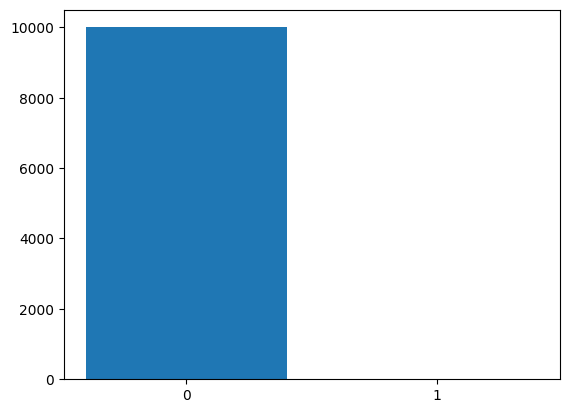

In [ ]:
#Implementation von iQPE für 2 Iterationen mit Theta=90°  : Erste Iteration

qc = rot_surf_code(2)

p = 0.01
p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
p_error_2 = pauli_error([["XX",p/6],["XI",p/6],["IX",p/6],["II",1-p],["ZZ",p/6],["ZI",p/6],["IZ",p/6]])

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(p_error, ['x', "z", 'h'])  # Apply to single-qubit gates
noise_model.add_all_qubit_quantum_error(p_error_2, ['cx'])  # Apply to 2-qubit gates

ancilla = qc.num_qubits - 3

qc = X_L(qc, False, n = 1)

qc = Hadamard(qc, pos=0)

qc = control_Z_L(qc,control=0,target=1)

qc = Hadamard(qc ,pos=0)

qc, round = QEC(qc, pos= 0, hadamard=False, iterations = 1, round = 3)

qc.reset(ancilla)

qc = Z_parity(qc,hadamard = False,pos=0)

qc.measure(ancilla,3)

shots = 10000
sim = AerSimulator()
job = sim.run(qc, shots=shots)
result = job.result()
counts = result.get_counts()

x = list(counts.keys())
x = [i[0] for i in x]
y_old = list(counts.values())

success  =  0
for i in range(len(x)):
    if x[i] == "1":
        success += y_old[i]

print("Erfolgsrate: ", success/shots)

y = [0,0]

for i in range(len(x)):
    if x[i] == "0":
        y[0] += y_old[i]
    elif x[i] == "1":
        y[1] += y_old[i]

x = ["0","1"]

plt.bar(x,y)

print("Wir erwarten 1 _ _ _: ",counts)

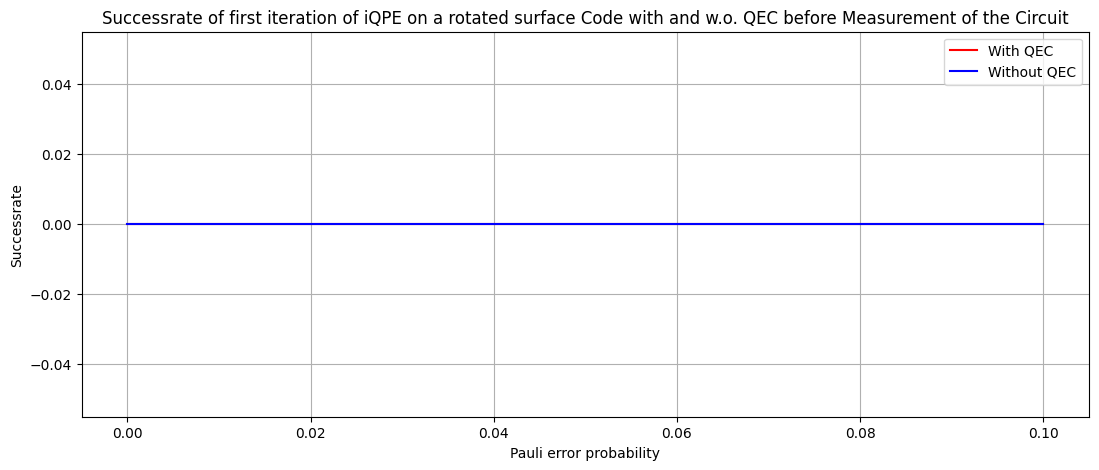

In [ ]:
x = np.linspace(0,0.1,20)
y = []
y_no_QEC = []
shots = 10
for i in x:
    # depolarizing_prob = i
    # dep_error = depolarizing_error(depolarizing_prob, 1)
    # dep_error_2q = depolarizing_error(depolarizing_prob, 2)
    # noise_model = NoiseModel()
    # noise_model.add_all_qubit_quantum_error(dep_error, ['x', "z",'h'])  # Apply to single-qubit gates
    # noise_model.add_all_qubit_quantum_error(dep_error_2q, ["cx"])  # Apply to 2-qubit gates

    p = i
    p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
    p_error_2 = pauli_error([["XX",p/6],["XI",p/6],["IX",p/6],["II",1-p],["ZZ",p/6],["ZI",p/6],["IZ",p/6]])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(p_error, ['x', "z", 'h'])  # Apply to single-qubit gates
    noise_model.add_all_qubit_quantum_error(p_error_2, ['cx'])  # Apply to 2-qubit gates
    
    qc = rot_surf_code(2)
    ancilla = qc.num_qubits - 3

    qc = X_L(qc, False, n = 1)
    qc = Hadamard(qc, pos=0)
    qc = control_Z_L(qc,control=0,target=1)
    qc = Hadamard(qc ,pos=0)

    qc, round = QEC(qc, pos= 0, hadamard=False, iterations = 1, round = 3)

    qc.reset(ancilla)

    qc = Z_parity(qc,hadamard = False,pos=0)

    qc.measure(ancilla,2)

    sim = AerSimulator()
    job = sim.run(qc, noise_model = noise_model, shots=shots)
    result = job.result()
    counts = result.get_counts()

    x_old = list(counts.keys())
    x_old = [j[0] for j in x_old]
    y_old = list(counts.values())

    success  =  0
    for j in range(len(x_old)):
        if x_old[j] == "1":
            success += y_old[j]
    Erfolgsrate = success/shots
    y.append(Erfolgsrate)
    ######################################## Nochmal aber ohne QEC
    qc = rot_surf_code(2)
    ancilla = qc.num_qubits - 3

    qc = X_L(qc, False, n = 1)
    qc = Hadamard(qc, pos=0)
    qc = control_Z_L(qc,control=0,target=1)
    qc = Hadamard(qc ,pos=0)
    qc.reset(ancilla)
    qc = Z_parity(qc,hadamard = False,pos=0)
    qc.measure(ancilla,3)

    sim = AerSimulator()
    job = sim.run(qc, noise_model = noise_model, shots=shots)
    result = job.result()
    counts = result.get_counts()

    x_old = list(counts.keys())
    x_old = [j[0] for j in x_old]
    y_old = list(counts.values())

    success  =  0
    for j in range(len(x_old)):
        if x_old[j] == "1":
            success += y_old[j]

    Erfolgsrate = success/shots
    y_no_QEC.append(Erfolgsrate)

data = np.array((x,y,y_no_QEC))
#np.savetxt("QEC_50k_shots_Pauli_XZ_compare.txt", data, delimiter=",")

fig, ax = plt.subplots(figsize=(13,5))

ax.plot(x,y,label = "With QEC", color="red")
ax.plot(x,y_no_QEC, label = "Without QEC", color="blue")
plt.title("Successrate of first iteration of iQPE on a rotated surface Code with and w.o. QEC before Measurement of the Circuit")
plt.xlabel("Pauli error probability")
plt.ylabel("Successrate")
plt.grid()
plt.legend()
plt.show()

Amount of gates in this circuit:  128


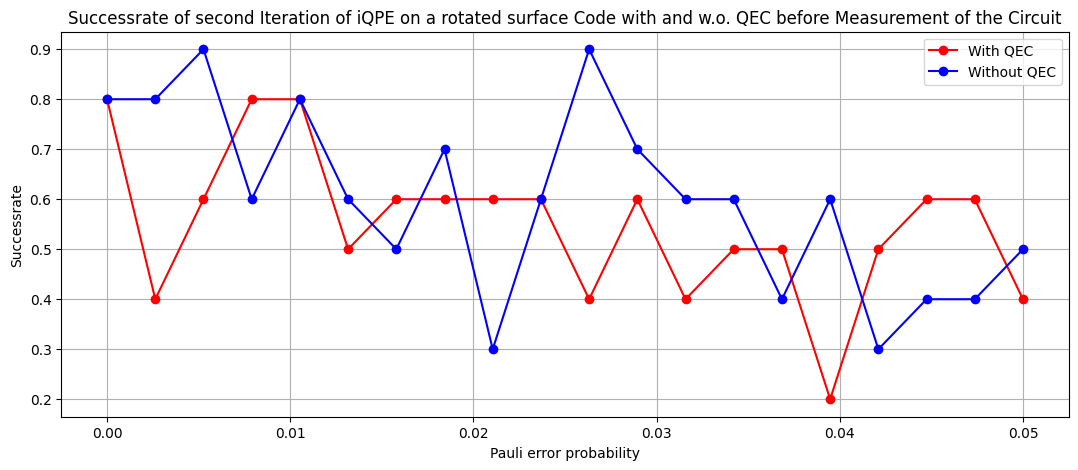

In [25]:
shots = 10
x = np.linspace(0,0.05,20)
y = []
y_no_QEC = []
for i in x:
    # depolarizing_prob = i
    # dep_error = depolarizing_error(depolarizing_prob, 1)
    # dep_error_2q = depolarizing_error(depolarizing_prob, 2)         #"s","t","tdg","sdg"
    # noise_model = NoiseModel()
    # noise_model.add_all_qubit_quantum_error(dep_error, ['x',"z",'h'])  # Apply to single-qubit gates
    # noise_model.add_all_qubit_quantum_error(dep_error_2q, ["cx"])  # Apply to 2-qubit gates

    p = i
    p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
    p_error_2 = pauli_error([["XX",p/6],["XI",p/6],["IX",p/6],["II",1-p],["ZZ",p/6],["ZI",p/6],["IZ",p/6]])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(p_error, ['x', "z", 'h'])  # Apply to single-qubit gates
    noise_model.add_all_qubit_quantum_error(p_error_2, ['cx'])  # Apply to 2-qubit gates

    
    qc = rot_surf_code(2)
    ancilla = qc.num_qubits - 3
    qc = X_L(qc, n = 1)
    qc = Hadamard(qc, 0)

    #qc = control_S_L(qc,"10",control = 0, target = 1)

    qc = new_T_L(qc, had=True, pos=0)
    qc = new_T_L(qc, had=False, pos=1)

    qc = QEC(qc, True, pos = 0, iterations=1)
    qc = QEC(qc, False, pos = 1, iterations=1)

    qc = CNOT(qc, hadamard="10",control=0)
    qc = new_adjoint_T_L(qc,had=False,pos=1)
    qc = CNOT(qc, hadamard="10",control=0)
    qc = new_adjoint_S_L(qc, had=True, pos = 0)
    qc = Hadamard(qc, 0)

    qc = QEC(qc, False, pos = 0, iterations=1)

    qc.reset(ancilla)
    qc = Z_parity(qc, pos = 0)

    qc.measure(ancilla,3)

    sim = AerSimulator()
    job = sim.run(qc, noise_model=noise_model, shots=shots)
    result = job.result()
    counts = result.get_counts()

    x_old = list(counts.keys())
    x_old = [j[0] for j in x_old]
    y_old = list(counts.values())

    success  =  0
    for j in range(len(x_old)):
        if x_old[j] == "0":
            success += y_old[j]
            
    Erfolgsrate = success/shots
    y.append(Erfolgsrate)
    ######################################## Nochmal aber ohne QEC
    qc = rot_surf_code(2)
    ancilla = qc.num_qubits - 3
    qc = X_L(qc, n = 1)
    qc = Hadamard(qc, 0)
    qc = new_control_S_L(qc,"10",control = 0, target = 1)
    qc = new_adjoint_S_L(qc, had=True, pos = 0)
    qc = Hadamard(qc, 0)
    qc.reset(ancilla)
    qc = Z_parity(qc, pos = 0)

    qc.measure(ancilla,3)
    
    sim = AerSimulator()
    job = sim.run(qc, noise_model = noise_model, shots=shots)
    result = job.result()
    counts = result.get_counts()

    x_old = list(counts.keys())
    x_old = [j[0] for j in x_old]
    y_old = list(counts.values())

    success  =  0
    for j in range(len(x_old)):
        if x_old[j] == "0":
            success += y_old[j]

    Erfolgsrate = success/shots
    y_no_QEC.append(Erfolgsrate)

data = np.array((x,y,y_no_QEC))
#np.savetxt("iQPE_2nd_step_7500_shots_ideal_magic_states_pauli_xz_new_5.txt", data, delimiter=",")

gates(qc)

fig, ax = plt.subplots(figsize=(13,5))

ax.plot(x,y,label = "With QEC", color="red", marker = "o")
ax.plot(x,y_no_QEC, label = "Without QEC", color="blue", marker = "o")
plt.title("Successrate of second Iteration of iQPE on a rotated surface Code with and w.o. QEC before Measurement of the Circuit")
plt.xlabel("Pauli error probability")
plt.ylabel("Successrate")
plt.grid()
plt.legend()
plt.show()